# NavWareSet SFM Calibration Case Study

This notebook demonstrates how to use the **NavWareSet** dataset to calibrate the Social Force Model (SFM) for human-robot interaction.
We will walk through downloading the dataset, importing necessary libraries, defining helper functions, loading and preparing the data,
setting up the model, running a simulation, computing the error between simulated and real trajectories, and visualizing the results.

## Table of Contents
1. [Step 1: Acquire Data & Install Dependencies](#step-1)
2. [Step 2: Import Libraries](#step-2)
3. [Step 3: Define Residuals Function](#step-3)
4. [Step 4: Define Helper Functions](#step-4)
5. [Step 5: Load Data](#step-5)
6. [Step 6: Prepare Data](#step-6)
7. [Step 7: Estimate Frame Rate & Initial States](#step-7)
8. [Step 8: Setup SFM Model & Simulate Trajectory](#step-8)
9. [Step 9: Evaluate & Visualize Results](#step-9)


## Step 1: Acquire Data & Install Dependencies
<a id="step-1"></a>

In this step, we download the CSV files from the NavWareSet-SFM repository and install the necessary Python library (`uaibot`)
used to simulate social force models. The dataset contains recorded pedestrian and robot trajectories in various scenarios.
Running the following cell will use `curl` to download the compressed dataset and `unzip` to extract the CSVs into the current working directory,
as well as install the UAIbot package from GitHub.


In [1]:
# Step 1: Download dataset and install dependencies
# This cell fetches the NavWareSet-SFM CSV files from GitHub and installs the UAIbot library needed for social force model simulations.
!curl -L https://github.com/anr-navware/NavWareSet-SFM/archive/refs/heads/main.zip -o repo.zip && unzip -j repo.zip '*.csv'
!pip install git+https://github.com/UAIbot/UAIbotPy.git@sfm#egg=uaibot

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 33587    0 33587    0     0  81627      0 --:--:-- --:--:-- --:--:-- 81627
Archive:  repo.zip
202773f7a31dbafc6b1520f68f7d88026f1c7a3a
  inflating: s_track_scene21_col2_from_1730212654962482432_to_1730212661562502400.csv  
  inflating: s_track_scene34_col2_from_1730825559930118656_to_1730825566930096384.csv  
  inflating: s_track_scene34_col3_from_1730825471131131392_to_1730825479230758400.csv  
  inflating: s_track_scene34_col4_from_1730825424931342336_to_1730825431731623424.csv  
  inflating: s_track_scene34_col4_from_1730825537130439168_to_1730825545730372352.csv  
  inflating: s_track_scene34_col5_from_1730825381931863552_to_1730825389331856384.csv  
  inflating: s_track_scene34_col5_from_1730825602529765376_to_1730825609829866496.csv  
  inflat

## Step 2: Import Libraries
<a id="step-2"></a>

Here we import all the required Python libraries for data processing, numerical computations, plotting, and simulation.
This includes `pandas` and `numpy` for data manipulation, `matplotlib` for plotting and animations, `uaibot` for the social force model
implementation, and utilities for working with file paths and system operations.


In [2]:
# Step 2: Import libraries
# Import standard numerical and plotting libraries, along with UAIbot for SFM and other utilities.
import pandas as pd
import numpy as np
import glob
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import uaibot as ub
import glob
import matplotlib.patches as patches
import sys, os
from IPython.display import Image, display
import uaibot as ub

## Step 3: Define Residuals Function
<a id="step-3"></a>

To calibrate the social force model parameters, it is often useful to quantify the difference between simulated trajectories
and real recorded trajectories. The `residuals` function defined in the following cell iterates through a list of dataframes
containing trajectory data, simulates pedestrian motion using given SFM parameters, and accumulates the total distance error.
This function is intended to be passed to optimization routines like `scipy.optimize.minimize` for parameter tuning.


In [3]:
# Step 3: Define residuals function for parameter tuning
# Define a helper function to compute residuals between simulated and real trajectories for optimization purposes.
def residuals(
    dfs,
    ta=0.3,
    va0=1.4,
    a_i=2.5,
    b_i=6,
    lambda_a=0.1,
    ro_radius=0.2,
    dt=0.1,
    t_max=10,
    tolerance=0.3
):
    total_distance = 0.0
    for df in dfs:
        initial_x = df['x'].iloc[0]
        initial_y = df['y'].iloc[0]
        final_x = df['x'].iloc[-1]
        final_y = df['y'].iloc[-1]
        robot_x = df['robot_x'].iloc[0]
        robot_y = df['robot_y'].iloc[0]

        ro = np.array([robot_x, robot_y])
        ra = np.array([initial_x, initial_y])
        g = np.array([final_x, final_y])

        # Create a Pedestrian object
        p = ub.Pedestrian(ra, g, va0=va0, a_i=a_i, b_i=b_i, lambda_a=lambda_a, ta=ta, radius=0.2)

        # Create robot as an obstacle
        obstacle = ub.ObstacleColumn(ro, radius=ro_radius, name="robot", color="red", height=1)

        positions = []
        t = 0
        k = 1
        while np.linalg.norm(p.ra - p.g) > tolerance and t < t_max:
            fag_result = p.fag()
            fdaq_result = p.fdaq(obstacle) * p.w(obstacle)
            p.va = p.va + (fag_result + fdaq_result) * dt
            p.ra = p.ra + p.va * dt
            try:
                new_robot_x = df['robot_x'].iloc[k]
                new_robot_y = df['robot_y'].iloc[k]
                new_ro = np.array([new_robot_x, new_robot_y])
                #if np.linalg.norm(p.ra - new_ro) < 0.6:
                #    p.ra = 1000*p.ra
                obstacle.ro = new_ro
            except:
                break
            positions.append(p.ra.flatten())
            t += dt
            k += 1

        positions = np.array(positions)
        min_len = min(len(positions), len(df))
        for i in range(min_len):
            csv_pos = (df['x'].iloc[i], df['y'].iloc[i])
            pred_pos = (positions[i, 0], positions[i, 1])
            dist = np.linalg.norm(np.array(csv_pos) - np.array(pred_pos))
            total_distance += dist

    return total_distance

def optimize_parameters(dfs):
    # Initial guess for parameters: ta, va0, a_i, b_i, lambda_a
    x0 = [0.3, 1.4, 2.5, 6.0, 0.1]
    bounds = [
        (0.1, 2.0),   # ta
        (0.5, 2.5),   # va0
        (0.1, 10.0),  # a_i
        (0.1, 10.0),  # b_i
        (0.01, 2.0)   # lambda_a
    ]

    def objective(x):
        ta, va0, a_i, b_i, lambda_a = x
        return residuals(dfs, ta=ta, va0=va0, a_i=a_i, b_i=b_i, lambda_a=lambda_a)

    result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')
    return result

if __name__ == "__main__":
    # Find all CSV files matching the pattern
    csv_files = sorted(glob.glob("s_track_scene*.csv"))
    if not csv_files:
        print("No CSV files found matching 'track_scene*.csv' in the current directory.")
    else:
        dfs = []
        for csv_file in csv_files:
            print(f"Loading: {csv_file}")
            df = pd.read_csv(csv_file)
            if 'timestamp' in df.columns:
                df = df.sort_values('timestamp')
            dfs.append(df)
        print("Optimizing parameters across all tracks...")
        result = optimize_parameters(dfs)
        print("Optimization result (shared across all tracks):")
        print(f"  ta       = {result.x[0]:.4f}")
        print(f"  va0      = {result.x[1]:.4f}")
        print(f"  a_i      = {result.x[2]:.4f}")
        print(f"  b_i      = {result.x[3]:.4f}")
        print(f"  lambda_a = {result.x[4]:.4f}")
        print(f"Sum of all differences between real and predicted values (all tracks): {result.fun:.4f}")

Loading: s_track_scene21_col2_from_1730212654962482432_to_1730212661562502400.csv
Loading: s_track_scene34_col2_from_1730825559930118656_to_1730825566930096384.csv
Loading: s_track_scene34_col3_from_1730825471131131392_to_1730825479230758400.csv
Loading: s_track_scene34_col4_from_1730825424931342336_to_1730825431731623424.csv
Loading: s_track_scene34_col4_from_1730825537130439168_to_1730825545730372352.csv
Loading: s_track_scene34_col5_from_1730825381931863552_to_1730825389331856384.csv
Loading: s_track_scene34_col5_from_1730825602529765376_to_1730825609829866496.csv
Loading: s_track_scene47_col1_from_1730220259995534336_to_1730220265195412480.csv
Loading: s_track_scene47_col2_from_1730220316194898432_to_1730220322894921472.csv
Loading: s_track_scene47_col4_from_1730220371394593280_to_1730220378094552320.csv
Loading: s_track_scene47_col4_from_1730220445693910272_to_1730220452093929472.csv
Loading: s_track_scene47_col5_from_1730220289295220480_to_1730220294495021312.csv
Loading: s_track

## Step 4: Define Helper Functions
<a id="step-4"></a>

Before loading the data and running the simulation, we define a couple of helper functions:
- `get_frame_rate`: Estimates the frame rate (frames per second) from timestamp differences in the recorded data.
- `trajectory_rmse_xy`: Computes the root-mean-square error between simulated and real (x, y) trajectories.

These functions will aid in preprocessing and evaluating the simulation.


In [4]:
# Step 4: Helper functions
# This cell defines `get_frame_rate` and `trajectory_rmse_xy` helper functions for frame rate estimation and trajectory error computation.
# ---------- helpers ----------
def get_frame_rate(df):
    if len(df) < 2:
        return None
    dt_ns = df['timestamp'].diff().dropna().median()
    return 1e9 / dt_ns if dt_ns and dt_ns > 0 else None

def trajectory_rmse_xy(sim_positions_xy, real_df):
    n = min(len(sim_positions_xy), len(real_df))
    if n == 0:
        return np.nan
    sim_xy = np.asarray(sim_positions_xy[:n])
    if sim_xy.ndim == 1:
        sim_xy = sim_xy.reshape(-1, 2)
    sim_xy = sim_xy[:, :2]
    real_xy = real_df[['x','y']].iloc[:n].to_numpy()
    return float(np.sqrt(np.mean(np.sum((sim_xy - real_xy)**2, axis=1))))


## Step 5: Load Data
<a id="step-5"></a>

Next, we load one of the recorded CSV files into a pandas DataFrame. The CSV files contain columns for timestamps, the pedestrian
position (`x`, `y`), and the robot position (`robot_x`, `robot_y`). We sort the data by timestamp to ensure correct chronological order
and check that all expected columns are present.


In [5]:
# Step 5: Load data
# This cell searches for the CSV files, selects one, loads it into a DataFrame, and verifies that all required columns are present.
# ---------- load data ----------
csv_files = sorted(glob.glob("s_track_scene*.csv"))
if not csv_files:
    print("No CSV files matching 's_track_scene*.csv' found.", file=sys.stderr)
    raise SystemExit(1)

csv_file = csv_files[-1]
print(f"Animating: {csv_file}")
df = pd.read_csv(csv_file)
if df.empty:
    print("CSV is empty.", file=sys.stderr)
    raise SystemExit(1)

for col in ['timestamp','x','y','robot_x','robot_y']:
    if col not in df.columns:
        print(f"Missing column: {col}", file=sys.stderr)
        raise SystemExit(1)


Animating: s_track_scene8_col3_from_1730818351095232256_to_1730818358495527424.csv


## Step 6: Prepare Data
<a id="step-6"></a>

After loading the data, we convert the timestamp column to floating point numbers and sort the DataFrame by time.
This preparation ensures consistent time intervals for the simulation and analysis.


In [6]:
# Step 6: Prepare data
# This cell converts the timestamp column to floating point and sorts the DataFrame by time to prepare for simulation.
df['timestamp'] = df['timestamp'].astype(float)
df = df.sort_values('timestamp').reset_index(drop=True)

fps_est = get_frame_rate(df)
print(f"Estimated frame rate: {fps_est:.2f} FPS" if fps_est else "Frame rate: unknown")


Estimated frame rate: 10.00 FPS


## Step 7: Estimate Frame Rate & Initial States
<a id="step-7"></a>

Using the `get_frame_rate` helper, we estimate the frame rate of the recording. We then extract the initial position of the pedestrian (`ra0`),
the goal position (`g`), and the initial position of the robot (`ro0`). We also define radii for both agents to model their personal space
in the social force model.


In [7]:
# Step 7: Estimate frame rate & initial states
# This cell calculates the frame rate of the recording and extracts the initial positions and radii for the pedestrian and robot.
# ---------- initial states ----------
ra0 = df[['x','y']].iloc[0].to_numpy()
g   = df[['x','y']].iloc[-1].to_numpy()
ro0 = df[['robot_x','robot_y']].iloc[0].to_numpy()

ra_radius = 0.2
ro_radius = 0.2


## Step 8: Setup SFM Model & Simulate Trajectory
<a id="step-8"></a>

Here we set up the social force model by specifying parameters such as relaxation time (`ta`), desired speed (`va0_des`),
interaction strength (`a_i`), range (`b_i`), and anisotropic interaction factor (`lambda_a`). We initialize the pedestrian object
and the robot obstacle, then simulate the pedestrian’s motion under the influence of goal attraction and repulsive forces
from the robot. The simulation runs until the pedestrian reaches the goal, a time limit is exceeded, or the end of the recorded data is reached.
We record the simulated positions and robot positions at each time step.


In [9]:
# Step 8: Setup SFM model & simulate trajectory
# This cell sets the SFM parameters, initializes the pedestrian and robot, and runs a simulation to compute positions over time.
# ---------- SFM parameters ----------
ta       = 0.2771
va0      = 1.5578
a_i      = 2.1541
b_i      = 5.1526
lambda_a = 0.4401

# ---------- model ----------
p = ub.Pedestrian(
    ra0, g, va0=va0, a_i=a_i, b_i=b_i, lambda_a=lambda_a, ta=ta, radius=ra_radius, name="pedestrian"
)
obstacle = ub.ObstacleColumn(ro0, radius=ro_radius, name="robot", color="red", height=1)

# ---------- sim ----------
dt = 0.1
t_max = 10.0
tolerance = 0.3

positions_xy = []
robots_xy = []
t = 0.0
k = 1

while np.linalg.norm(p.ra - p.g) > tolerance and t < t_max and k < len(df):
    fag = p.fag()
    fdaq = p.fdaq(obstacle) * p.w(obstacle)
    p.va = p.va + (fag + fdaq) * dt
    p.ra = p.ra + p.va * dt

    obstacle.ro = df[['robot_x','robot_y']].iloc[k].to_numpy()

    positions_xy.append(p.ra.copy().flatten()[:2])
    robots_xy.append(obstacle.ro.copy().flatten()[:2])

    t += dt
    k += 1

if not positions_xy or not robots_xy:
    print("No simulated steps. Start near goal or t_max too small.", file=sys.stderr)
    raise SystemExit(0)

positions_xy = np.vstack(positions_xy)
robots_xy = np.vstack(robots_xy)


## Step 9: Evaluate & Visualize Results
<a id="step-9"></a>

Finally, we compute the root-mean-square error (RMSE) between the simulated trajectory and the recorded trajectory using `trajectory_rmse_xy`.
We then visualize both trajectories by plotting the recorded person and robot paths alongside the simulated paths.
An animation is generated and saved as a GIF to illustrate the movement over time.


Trajectory RMSE vs CSV: 0.360 m
Saved trajectory.gif (637.6 KiB) at 10 fps


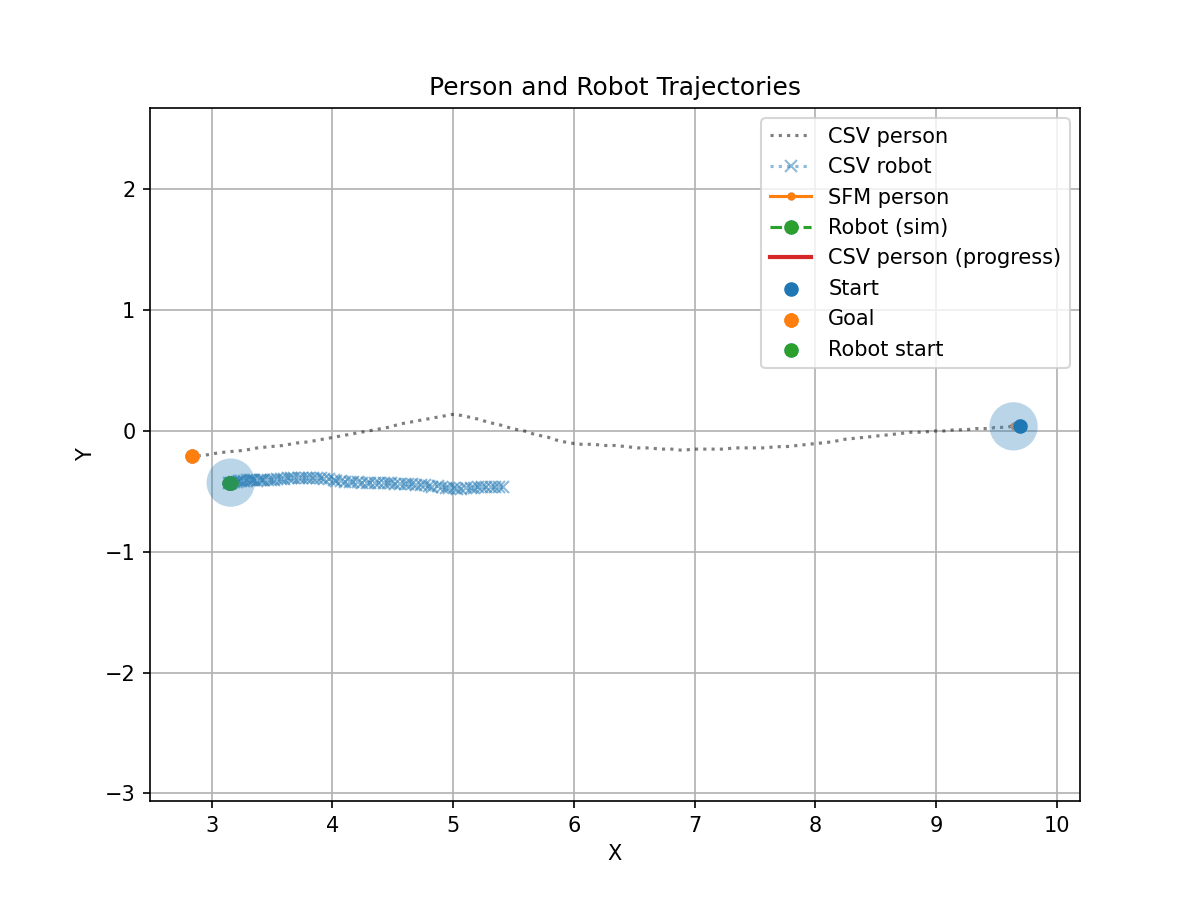

In [10]:
# Step 9: Evaluate & visualize results
# This cell computes the RMSE, plots the trajectories, animates the simulation, and saves the result as a GIF.
rmse = trajectory_rmse_xy(positions_xy, df)
print(f"Trajectory RMSE vs CSV: {rmse:.3f} m")

# ---------- plot / animate ----------
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df['x'], df['y'], 'k:', alpha=0.5, label='CSV person')
ax.plot(df['robot_x'], df['robot_y'], linestyle=':', marker='x', alpha=0.5, label='CSV robot')

xmin = min(positions_xy[:,0].min(), robots_xy[:,0].min(), df['x'].min(), df['robot_x'].min()) - 1
xmax = max(positions_xy[:,0].max(), robots_xy[:,0].max(), df['x'].max(), df['robot_x'].max()) + 1
ymin = min(positions_xy[:,1].min(), robots_xy[:,1].min(), df['y'].min(), df['robot_y'].min()) - 1
ymax = max(positions_xy[:,1].max(), robots_xy[:,1].max(), df['y'].max(), df['robot_y'].max()) + 1
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

person_line, = ax.plot([], [], '.-', label='SFM person')
robot_line,  = ax.plot([], [], '--o', label='Robot (sim)')
human_csv_line, = ax.plot([], [], '-', linewidth=2, label='CSV person (progress)')

robot_circle = patches.Circle(robots_xy[0], ro_radius, alpha=0.3, zorder=10)
person_circle = patches.Circle(positions_xy[0], ra_radius, alpha=0.3, zorder=10)
ax.add_patch(robot_circle)
ax.add_patch(person_circle)

ax.scatter([ra0[0]], [ra0[1]], label='Start', zorder=5)
ax.scatter([g[0]],   [g[1]],   label='Goal',  zorder=5)
ax.scatter([ro0[0]], [ro0[1]], label='Robot start', zorder=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Person and Robot Trajectories')
ax.legend()
ax.grid(True)
ax.axis('equal')

def init():
    person_line.set_data([], [])
    robot_line.set_data([], [])
    human_csv_line.set_data([], [])
    robot_circle.center = tuple(robots_xy[0])
    person_circle.center = tuple(positions_xy[0])
    return person_line, robot_line, human_csv_line, robot_circle, person_circle

def animate(i):
    person_line.set_data(positions_xy[:i+1,0], positions_xy[:i+1,1])
    robot_line.set_data(robots_xy[:i+1,0], robots_xy[:i+1,1])

    j = min(i+1, len(df))
    human_csv_line.set_data(df['x'].iloc[:j], df['y'].iloc[:j])

    if i < len(robots_xy):
        robot_circle.center = tuple(robots_xy[i])
    if i < len(positions_xy):
        person_circle.center = tuple(positions_xy[i])
    return person_line, robot_line, human_csv_line, robot_circle, person_circle

interval_ms = int(1000*dt if fps_est is None else 1000/max(fps_est, 1))
ani = animation.FuncAnimation(
    fig, animate, frames=len(positions_xy), init_func=init,
    blit=False, interval=interval_ms, repeat=False
)

# ---------- save and display GIF ----------
fps_out = max(int(round(1000/interval_ms)), 1)
out_gif = "trajectory.gif"

ani.save(out_gif, writer="pillow", fps=fps_out, dpi=150)
plt.close(fig)
print(f"Saved {out_gif} ({os.path.getsize(out_gif)/1024:.1f} KiB) at {fps_out} fps")
display(Image(filename=out_gif))
